In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

In [ ]:

import os
import sys
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision
import torchvision.utils
import torchvision.models as models
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable


use_gpu = torch.cuda.is_available()

In [ ]:
def get_model(model_name, pretrained=True):
    return models.__dict__[model_name](pretrained)


def imshow(img, text=None):
    img_np = img.numpy().transpose((1, 2, 0))
    plt.axis("off")
    if text:
        plt.text(175, 8, text, style='italic', fontweight='bold',
                 bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 10})
    plt.imshow(img_np)
    plt.show()

In [ ]:
DATA_DIR = '/content/drive/MyDrive/MoeinHeidari_Files/datasets/ubiris_final_splitted/'
train_dir = '/content/drive/MyDrive/MoeinHeidari_Files/datasets/ubiris_final_splitted/train'
valid_dir = f'{DATA_DIR}valid'

sz = 200
batch_size = 16
embed_size = 128
num_epochs = 50

cnn_name = 'resnet101'

In [ ]:
cd /content/drive/MyDrive/MoeinHeidari_Files/datasets/ubiris_final_splitted

/content/drive/MyDrive/MoeinHeidari_Files/datasets/ubiris_final_splitted


In [ ]:
import os
import glob
import shutil
import random
from tqdm import tqdm


def create_validation_data(trn_dir, val_dir, split=0.1, ext='png'):
    if not os.path.exists(val_dir):
       os.mkdir(val_dir)
        
    train_ds = glob.glob(trn_dir + f'/*/*.{ext}')
    print((train_ds)[0])
    
    valid_sz = int(split * len(train_ds)) if split < 1.0 else split 
    
    valid_ds = random.sample(train_ds, valid_sz)
    print(len(valid_ds))
    
    for fname in tqdm(valid_ds):
        basename = os.path.basename(fname)
        label = fname.split('/')[-2]
        src_folder = os.path.join(trn_dir, label)
        tgt_folder = os.path.join(val_dir, label)
        if not os.path.exists(tgt_folder):
            os.mkdir(tgt_folder)
        shutil.move(os.path.join(src_folder, basename), os.path.join(tgt_folder, basename))
		

def pseudo_label(probs, tst_dir, test_dl, class_names, threshold=0.99999):
    num_data = len(test_dl.dataset)
    preds = np.argmax(probs, axis=1)
    candidate_idxs = np.arange(num_data)[probs.max(axis=1) >= threshold]
    
    fnames = [f[0].split('/')[-1] for f in test_dl.dataset.imgs]
    imgs = [fnames[i] for i in candidate_idxs]
    labels = [class_names[preds[i]] for i in candidate_idxs]
    
    dest_folder = os.path.join(DATA_DIR, 'pseudo', 'train')
#      for name in class_names:
#          folder = os.path.join(dest_folder, name)
#          if not os.path.exists(folder):
#              os.mkdir(folder)
        
    for _, (img, label) in tqdm(enumerate(zip(imgs, labels))):
        src = os.path.join(tst_dir, 'unk', img)
        dst = os.path.join(dest_folder, label, img)
        if not os.path.exists(dst):
            shutil.copyfile(src, dst)

In [ ]:
# make validation dataset
if not os.path.exists(valid_dir):
    create_validation_data(train_dir, valid_dir, split=0.20, ext='png')

In [ ]:
class TripletNetworkDataset(Dataset):
    
    def __init__(self, imgs, transform=None):
        self.imgs = imgs
        self.transform = transform
        if transform is None:
            self.transform = transforms.ToTensor()
        
    def __getitem__(self, index):
        # Select anchor image and its label from dataset
        anchor, anchor_label = self.imgs[index]
        
        # Randomly select a positive and a negative example
        positive = random.choice([img for img, lbl in self.imgs if lbl == anchor_label])
        negative = random.choice([img for img, lbl in self.imgs if lbl != anchor_label])
        
        # read the images (anchor, positive and negative images)
        anc_img = Image.open(anchor).convert('RGB')
        pos_img = Image.open(positive).convert('RGB')
        neg_img = Image.open(negative).convert('RGB')
        
        # perform any required transformation (if any)
        if self.transform is not None:
            anc_img = self.transform(anc_img)
            pos_img = self.transform(pos_img)
            neg_img = self.transform(neg_img)
        
        return anc_img, pos_img, neg_img
    
    def __len__(self):
        return len(self.imgs)

In [ ]:
zoom = int((1.0 + random.random() / 10.0) * sz)  # up to 10 percent zoom

tfms = transforms.Compose([
    transforms.Resize((zoom, zoom)),
    transforms.RandomCrop(sz),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(5),
    transforms.ToTensor()
])

face_dataset = datasets.ImageFolder(train_dir)
train_ds = TripletNetworkDataset(face_dataset.imgs, transform=tfms)
train_dl = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=0)

In [ ]:
valid_tfms = transforms.Compose([
    transforms.Resize((zoom, zoom)),
    transforms.RandomCrop(sz),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(5),
    transforms.ToTensor()
])

valid_face_dataset = datasets.ImageFolder(valid_dir)
valid_ds = TripletNetworkDataset(valid_face_dataset.imgs, transform=valid_tfms)
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=True, num_workers=0)

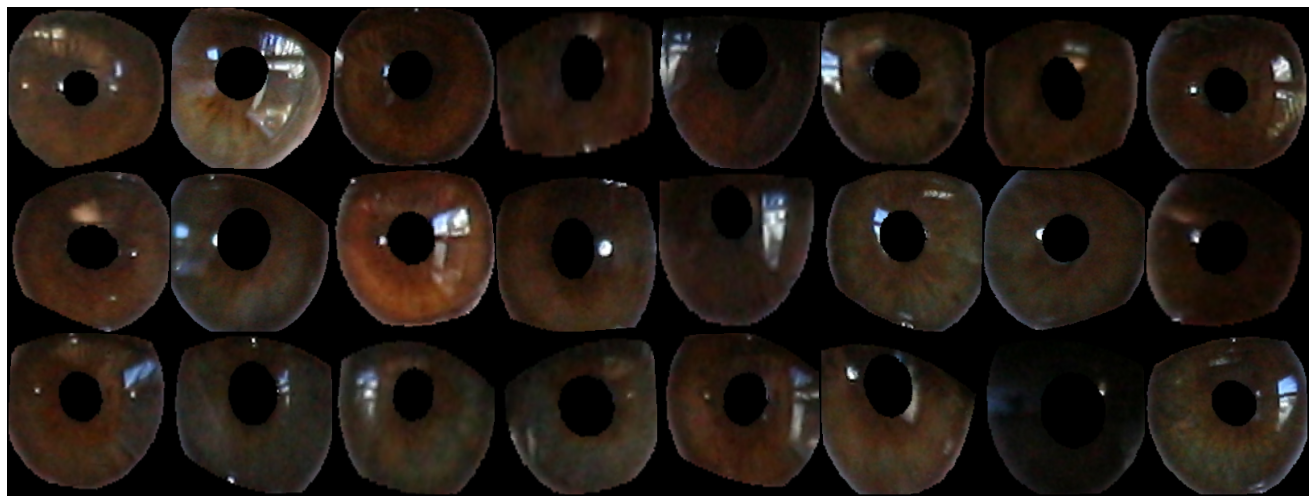

In [ ]:
anch_imgs, pos_imgs, neg_imgs = next(iter(train_dl))
concat = torch.cat((anch_imgs, pos_imgs, neg_imgs), 0)
plt.figure(figsize=(24, 9))
imshow(torchvision.utils.make_grid(concat, nrow=8))

In [ ]:
class TripletNetwork(nn.Module):
    
    def __init__(self, model, embed_size):
        super(TripletNetwork, self).__init__()
        num_features = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),           
            nn.Linear(512, embed_size))
        self.model = model
        
    def forward(self, anc, pos, neg):
        f_anc = self.model(anc)
        f_pos = self.model(pos)
        f_neg = self.model(neg)
        return f_anc, f_pos, f_neg

In [ ]:
class TripletLoss(nn.Module):

    def __init__(self, margin=0.2):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, f_anc, f_pos, f_neg):
        pos_distance = F.pairwise_distance(f_anc, f_pos)
        neg_distance = F.pairwise_distance(f_anc, f_neg)
        loss = torch.sum(torch.clamp(torch.pow(pos_distance, 2) - \
                                     torch.pow(neg_distance, 2) + self.margin, min=0))
        return loss

In [ ]:
def train_step(model, train_dl, criterion, optimizer, scheduler=None):
    model.train()
    if scheduler:
        scheduler.step()
    
    N = len(train_dl.dataset)
    steps = N // train_dl.batch_size
    avg_loss = 0.0
    for i, (anc, pos, neg) in enumerate(train_dl):
        anc, pos, neg = Variable(anc).cuda(), Variable(pos).cuda(), Variable(neg).cuda()
        
        # forward
        f_anc, f_pos, f_neg = model(anc, pos, neg)
        
        # loss
        loss = criterion(f_anc, f_pos, f_neg)
        avg_loss = (avg_loss * i + loss.data) / (i + 1)
        
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # report
        sys.stdout.flush()
        sys.stdout.write("\r Training Step [{:2d}/{:2d}]: loss {:.5f}  ".format(i+1, steps, avg_loss))
    print()

    return model, avg_loss    


def validate_step(model, valid_dl, criterion):
    model.eval()
    
    N = len(valid_dl.dataset)
    steps = N // valid_dl.batch_size
    avg_loss = 0.0
    for i, (anc, pos, neg) in enumerate(valid_dl):
        anc = Variable(anc, volatile=True).cuda()
        pos = Variable(pos, volatile=True).cuda()
        neg = Variable(neg, volatile=True).cuda()
        
        f_anc, f_pos, f_neg = model(anc, pos, neg)
        loss = criterion(f_anc, f_pos, f_neg)
        avg_loss = (avg_loss * i + loss.data) / (i + 1)
        
        # report
        sys.stdout.flush()
        sys.stdout.write("\r Validation Step [{:2d}/{:2d}]: loss {:.5f}  ".format(i+1, steps, avg_loss))
    print()
    
    return avg_loss


def train(model, train_dl, valid_dl, criterion, optimizer, scheduler=None, num_epochs=100):
    best_loss = float('inf')
    best_weights = model.state_dict().copy()
    
    train_loss_history, valid_loss_history = [], []
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}\n--------')
        model, train_loss = train_step(model, train_dl, criterion, optimizer, scheduler)
        valid_loss = validate_step(model, valid_dl, criterion)
        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)
        if valid_loss < best_loss:
            best_loss = valid_loss
            best_weights = model.state_dict().copy()
        print()
    loss_history = (train_loss_history, valid_loss_history)
    return model, best_weights, loss_history

In [ ]:
# data
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=0)
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=False, num_workers=0)

# model
cnn = get_model(cnn_name)
model = TripletNetwork(cnn, embed_size).cuda()

# loss and optimizer
criterion = TripletLoss().cuda()
optimizer = optim.Adam(model.parameters(), lr=0.0002)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.95)

Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

In [ ]:
model, best_weights, loss_hist = train(model, train_dl, valid_dl, 
                                       criterion, optimizer, scheduler, 
                                       num_epochs=num_epochs)

Epoch 0
--------


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


 Training Step [113/112]: loss 23.98506  


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


 Validation Step [29/28]: loss 8.19662  

Epoch 1
--------
 Training Step [113/112]: loss 3.19464  
 Validation Step [29/28]: loss 1.87516  

Epoch 2
--------
 Training Step [113/112]: loss 1.76527  
 Validation Step [29/28]: loss 1.05566  

Epoch 3
--------
 Training Step [113/112]: loss 1.27214  
 Validation Step [29/28]: loss 0.87227  

Epoch 4
--------
 Training Step [113/112]: loss 0.90038  
 Validation Step [29/28]: loss 0.75602  

Epoch 5
--------
 Training Step [113/112]: loss 0.77972  
 Validation Step [29/28]: loss 0.63455  

Epoch 6
--------
 Training Step [113/112]: loss 0.68042  
 Validation Step [29/28]: loss 0.56926  

Epoch 7
--------
 Training Step [113/112]: loss 0.53902  
 Validation Step [29/28]: loss 0.48796  

Epoch 8
--------
 Training Step [113/112]: loss 0.56524  
 Validation Step [29/28]: loss 0.74536  

Epoch 9
--------
 Training Step [113/112]: loss 0.56765  
 Validation Step [29/28]: loss 0.36964  

Epoch 10
--------
 Training Step [113/112]: loss 0.43932  

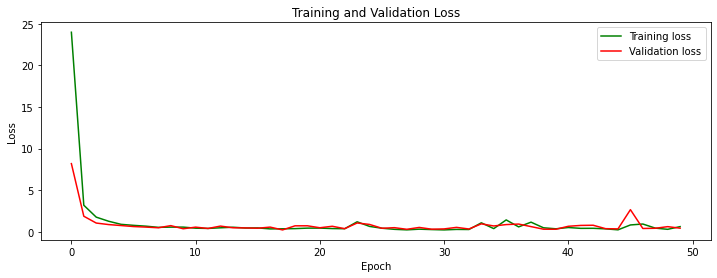

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(loss_hist[0], 'g', label='Training loss')
plt.plot(loss_hist[1], 'r', label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title("Training and Validation Loss");

In [ ]:
torch.save(model.state_dict(), f'{cnn_name}-facereco-triplet-{num_epochs}.pth')


let's test:)))

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/MoeinHeidari_Files/resnet101-facereco-triplet-50.pth'))


<All keys matched successfully>

In [ ]:
valid_dl = DataLoader(valid_ds, batch_size=1, shuffle=True)


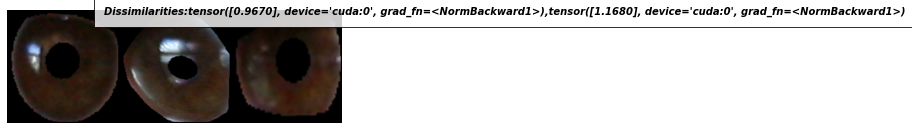

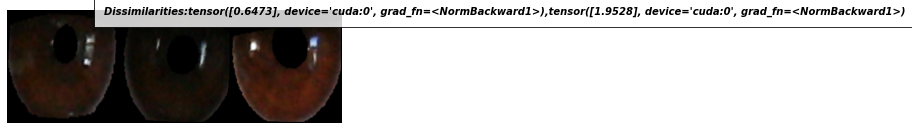

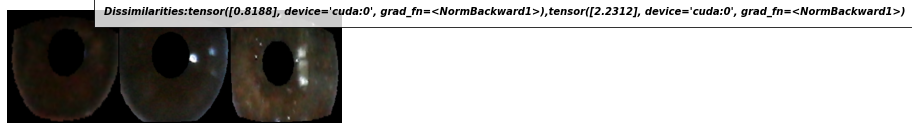

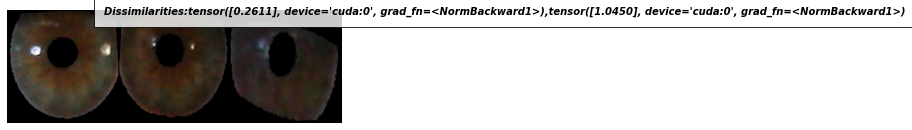

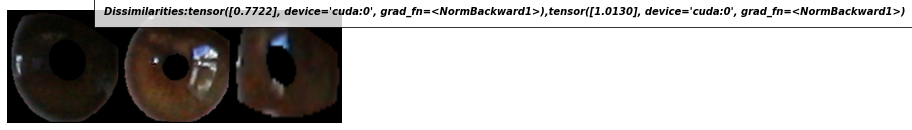

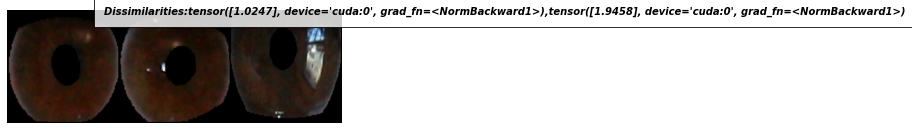

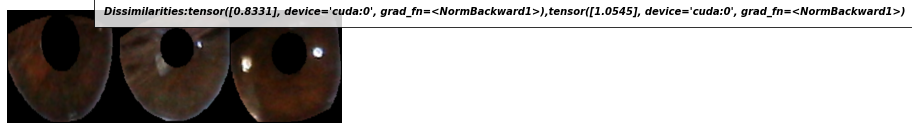

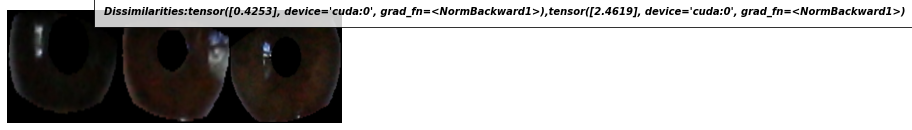

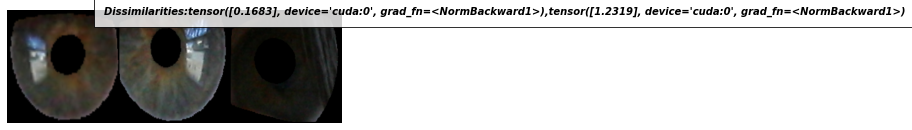

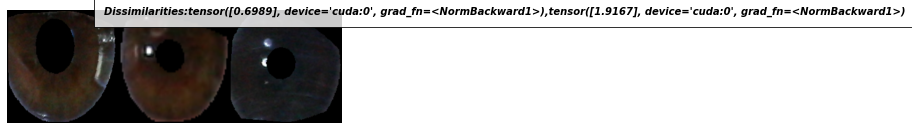

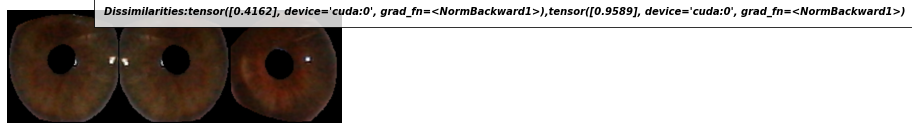

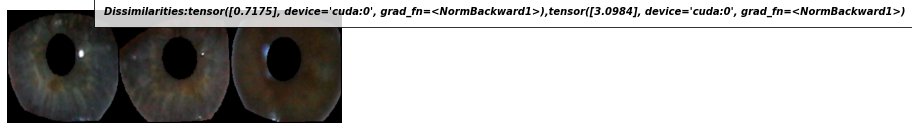

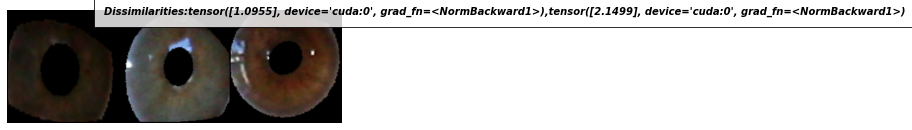

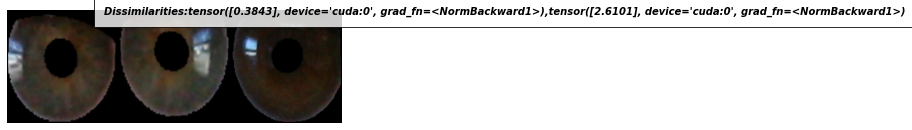

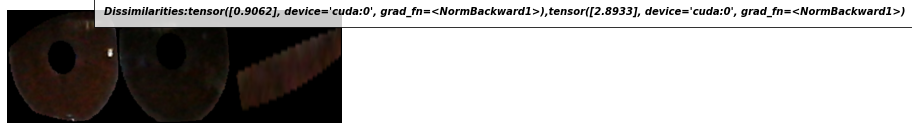

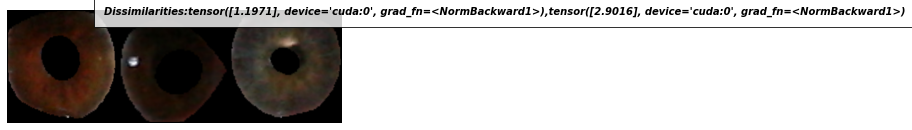

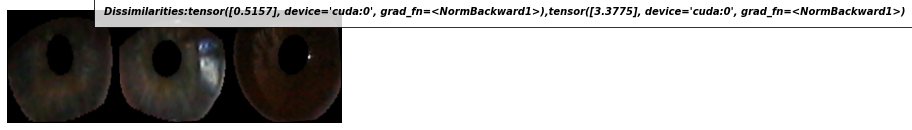

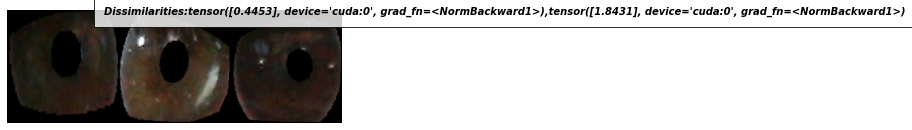

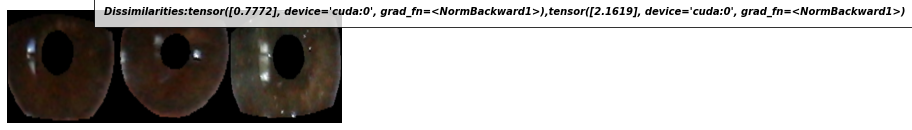

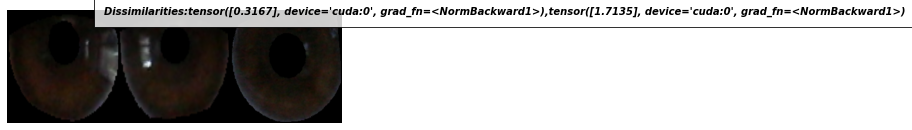

In [ ]:
model.eval()

dataiter = iter(valid_dl)
for i in range(20):
    x0, x1, x2 = next(dataiter)
    concat = torch.cat((x0, x1, x2), 0)
    f0, f1, f2 = model(Variable(x0).cuda(), Variable(x1).cuda(), Variable(x2).cuda())
    pos_distance = F.pairwise_distance(f0, f1)
    neg_distance = F.pairwise_distance(f0, f2)
    imshow(torchvision.utils.make_grid(concat), 'Dissimilarities:{},{}'.format(pos_distance, 
                                                                                           neg_distance))